# Intermediate - Statistical Tests & Regression

### Andy and Juan Notes to Complete in Notebook
### Delete once finished
Intermediate Section Activities (Statistical Testing / Regression):
- Statistical libraries
    * Scipy, statsmodels
- Stats simulations
    * Use sims to determine desired sample size for some power of test
    * Alternatively evaluate power based on given sample size
- Create user defined functions
    * Write function for simulation
- Statistical Tests
    * Test for statistically significant difference in 1 gene between two cancer types
        * Do this for a specific gene identified as important for treatment
    * ANOVA on one gene versus all other cancer types
- Regression using library for 2 cancer types for specific gene(s)
    * Linear / Logistic regression


# Overview

This is the intermediate level notebook for the Data Science (DS) and Machine Learning (ML) FredHutch.io tutorial, where we will work through beginning to end on different aspects and techniques in DS for Statistical Testing in Research and Data Analysis.

In this notebook we will work through the process of data analysis for the [gene expression cancer RNA-Seq Data Set](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#). **We will be using some findings from the Beginner Tutorial Notebook.**

This is the intermediate notebook and we will  focusing specifically on statistical testing and regression models in **python**. We will keep working with *python libraries* introduced in the Beginner Tutorial and introduce some new libraries with special purposes in statistics.
> **Libraries Used in This Tutorial**
* Data Manipulation and Processing
     - [pandas]( https://pandas.pydata.org/)
     - [numpy]( https://numpy.org/)
* Data Visualization
	- [Matplotlib](https://matplotlib.org/)
    - [Seaborn](https://seaborn.pydata.org/)
    - [Altair](https://altair-viz.github.io/)
* Statistics
    - [SciPy](https://www.scipy.org/)
    - [Statsmodels](https://www.statsmodels.org/stable/index.html)

## Questions

In this Notebook, we are focused on figuring out the statistically significant differences in genes between cancer groups. We are also concerned with determining statistical power our experiment given the genes data inspired by the PANCAN dataset.

# Table of Contents

[1. Statistical Background](#1.-Statistical-Background)
* [1.1 Hypothesis Testing](#1.1-Hypothesis-Testing)
    - [1.1.2 Steps in Statistical Testing](#1.1.2-Steps-in-Statistical-Testing)
        - [Step 1: Hypotheses](#Step-1:-Hypotheses)
        - [Step 2: Significance](#Step-2:-Significance)
        - [Step 3: Test Statistic](#Step-3:-Test-Statistic)
    - [1.1.3 P Value](#1.1.3-P-Value)
    - [1.1.4 Statistical Significance](#1.1.4-Statistical-Significance)

* [1.2 Statistical Power and Sample Size Calculations](#1.1-Statistical-Power-and-Sample-Size-Calculations)
    - [1.2.1 One-Sample Population Calculations](#1.1.1-One-Sample-Population-Calculations)
    - [1.2.2 Comparing Two Samples Calculations](#1.1.2-Comparing-Two-Samples-Calculations)

[2. Setup](#2.-Setup)

* [2.1 Importing Python Libraries](#2.1-Importing-Python-Libraries)
     - [2.1.1 Imports](#2.1.1-Imports)
     - [2.1.2 Load TCGA Data](#2.1.2-Load-TCGA-Data)

[3. Hypothesis Testing](#3.-Hypothesis-Testing)
* [3.1 T test on One Sample](#3.1-T-test-on-One-Sample)


[4. Power and Sample Size](#4. Power-and-Sample-Size)

# 1. Statistical Background

## 1.1 Hypothesis Testing

Hypothesis tests are used to answer questions about a population. Given gene abundance data we've been looking at, you might ask a question like:

> Do the average count levels of 'gene X' differ between people with 'cancer Y' versus 'cancer Z?'

Without any further knowledge, the best you could do is look at graphs or summary statistics from your samples. The means of your samples, however, are not good enough - you want to base your decision on the underlying populations. How can you know anything about the whole population? This is where statistical hypothesis testing comes in!

### 1.1.1 What does testing do?

Basic hypothesis testing essentially asks: what is the probability that our sample came from a population with distribution A versus distribution B?
For example, how likely is it that our sample came from a distribution with a mean count = X for a gene expression?
Hypothesis testing is a standardized and quantitative framework from which to answer questions like this. Otherwise, you'd be left eyeing out graphs and speculating.

### 1.1.2 Steps in Statistical Testing

#### Step 1: Hypotheses

As we stated before, the first thing you need to perform a statistical test is a hypothesis, you need to know what you want to find out of course. 

We always decide on a **Null Hypothesis** $H_{0}$ which is the base case. 
Then we decide on an **Alternative Hypothesis** $H_{1}$, which contradicts $H_{0}$.

In our imagined scenario above, our hypotheses would be:

> The mean count is $X$; $H_{0}$: $\mu = X$ 
>
> The mean count is not $X$; $H_{1}$: $\mu \neq X$ 

**IMPORTANT NOTE**
_Using hypothesis testing, there are only two ways to interpret the outcome: you reject the Null Hypothesis, or you fail to reject it. The Null cannot be proven to be true._

#### Step 2: Significance

Based on the above note, there are essentially four possible outcomes and two ways that our hypothesis test outcome could turn out to be wrong:

True Statement | Reject $H_{0}$ | Do Not Reject $H_{0}$
--------------|-------------|--------------------
$H_{0}$ is True | ***Type I Error*** | *Correct Decision*
$H_{0}$ is False | *Correct Decision* | ***Type II Error***

> **Type I Error:** Rejecting the Null when it is actually true
>
> **Type II Error:** 'Accepting' the Null when it is actually false

The probability of having a Type I error is called the **significance level** of a hypothesis test.
Significance level: $\alpha$

The probability of having a Type II error is denoted by $\beta$.

The **power level** of a test is 1 - $\beta$. In other words, the probability of _"accepting"_ the Null when it is actually true. 
Utimately, we want to perform a test that __minimizes $\alpha$ and maximises power.__ The catch is that *$\alpha$ and $\beta$ are inversely related*. 

In designing our experiment, the way around this is to specify the $\alpha$ beforehand, and then try to maximize power.
A commonly used value is $\alpha = 0.05$, but depending on the field other values such as 0.025 or 0.01 are often
commonly used. We then we try to achieve a high value for the power, e.g., 0.8 or 0.9, or higher, depending on the context. Achieving high power typically requires selecting a sufficiently large sample size.

#### Step 3: Test Statistic
A test statistic is a standardized value that is calculated in place of just using the sample mean. This standardizes the testing process and is mathematically more convenient.
One such 'test statistic' is the **t** value:
$$
t = \frac{\overline{x} - m_{0}}{s * \sqrt{n}}
$$
>$\overline X$ - sample mean  
$\mu_0$ - population mean (Null Hypothesis)  
$\sigma$ - standard deviation  
$n$ - sample size 

T follows something called a t distribution. Based on the $\alpha$ decided on for the test, and the sample size, the t distribution is used to calculate a **critical value**, which t is compared to.

This comparison determines the outcome of a test.

For example, if $\alpha = 0.05$ and **t > criticial value**, we would reject $H_{0}$ at significance of 0.05.

#### [Optional]Step 4: Confidence Intervals
Confidence interval is an interval calculated from the data using a rule which ensures that the interval has a certain pre-specified probability (often 95%, _1-$\alpha$_ ) of containing the true value of the target parameter.

The formula to calculate the _Confidence Interval_ is then:
$$
C.I. = \overline X - (Critical \ Value) * (\frac{\sigma}{\sqrt{n}})
$$
> $\overline X$ - sample mean  
$Critical \ Value$ - either Z or t statistic at the desired $\alpha$  
$\sigma$ - standard deviation  
$n$ - sample size


### 1.1.3 P Value
The **p value** is another way of deciding on the overall significance of your test outcome. It represents the probability of getting a more extreme result than what you got given the Null Hypothesis. Intuitively, if **p** is small, it indicates our test results are statistically significant.
A commonly used value is 0.05. If p < 0.05 you can say your test result is statistically significant.

### 1.1.4 Statistical Significance
Given the above, there are 2 ways to determine the statistical significance of a test:

1. Calculate test statistic (t), compare it to the critical value given a significance level ($\alpha = 0.05$). In the case of $H_{0}: mean = 0$ and $H_{1}: mean > 0$, if t > critical value, we reject $H_{0}$ and the result is *statistically significant*. Otherwise, we fail to reject, and the result is *not statistically significant*.

2. Calculate the p value, if p < 0.05, we reject $H_{0}$ and the result is *statistically significant*. Otherwise, we fail to reject, and the result is *not statistically significant*.

These methods are completely equivalent. As you will see below, modern statistical testing packages will offer both versions of the result.

## 1.2 Statistical Power and Sample Size Calculations

In designing our experiments, one of the most important aspects is the choice of a proper sample size, too small we wont yield useful information, too large we then waste time and resources.

To find an answer to our main questions in this notebook, and any research in general, we must decide which particular alternative *Hypothesis*, or *$H_{1}$*, are important to be able to detect with high ***power***.

In statistics, we refer to the **power** of an experiment as the control over the *type II* error rate:

> **Power = *P* (Reject *$H_{0}$* given that the alternative *$H_{1}$* holds)**  
Also written as  
**Power = 1 - *P* (Type II error) = 1 - $\beta$**

Power calculations are an important aspect of experimental design, as it might tell us if the results of our study are statistically significant or even if results from previous studies are incorrect.  

We can perform the calculations in a variety of ways:
* formulas
* simulations
* on-line calculators, *like this [one]( https://www.stat.ubc.ca/~rollin/stats/ssize/n2.html)*
* commercial software

In this notebook we’ll work with both simulations and formulas. These formulas are based on familiar assumptions such as:
- independence in our sample data
- normality of errors  
- constant variance 

so they are often thought of as an initial rough calculation of power.

The formulas we will be using are then derived from the general formula for the Z test statistic
$$
Z=\frac{\overline X - \mu_{0}}{\frac{\sigma}{\sqrt[]{n}}} \\	
$$
>$\overline X$ - sample mean  
$\mu_0$ - population mean (Null Hypothesis)  
$\sigma$ - standard deviation  
$n$ - sample size  


We algebraically manipulate the formula and allow for $Z$ to be dependent on the desired significance level $\alpha$ for the quantile values in the Normal Distribution, $N(0,1)$. The power of the test for a mean is _increased_ by:

1. Increasing the difference between the means under the
null and alternative hypotheses ($\mu_1 - \mu_0$).
2. Increasing the significance level ($\alpha$).
3. Decreasing the standard deviation ($\sigma$).
4. Increasing the sample size ($n$).

### 1.2.1 One-Sample Population Calculations

> $$
\hbox{Power} = P\left( N(0,1) <
	-Z_{1 - \alpha / 2} + \frac{ |\mu_1 - \mu_0|}{ \sigma / \sqrt n } \right) = 	\Phi(-Z_{1 - \alpha / 2} + \frac{ |\mu_1 - \mu_0|}{ \sigma / \sqrt n } ),
$$
where $\Phi$ is the cdf of the N(0,1) distribution.

The sample size that is required in order to have power equal to $1-\beta$:
> $$
	n = \frac{ \sigma^2 (Z_{1 - \beta} + Z_{1 - \alpha / 2})^2}{ (\mu_0 - \mu_1)^2 }.
$$

### 1.2.2 Comparing Two Samples Calculations

When looking at comparing 2 samples, we consider the test of $H_0:\mu_A=\mu_B$ versus
$H_0:\mu_A\neq\mu_B$, where $\mu_A$ and $\mu_B$ are
means of two populations. Assuming a known population
variance $\sigma^2$ and sample sizes $n$ per group,
test statistic is 
> $$
Z=\frac{|\bar X_A - \bar X_B|}{\sqrt{\sigma_A^2/n_A+\sigma_B^2/n_B} },
$$

As a result, our power and sample size formulas become
> $$
\hbox{Power} = \Phi ( -Z_{1 - \alpha / 2} + \frac{|\Delta|}{ \sqrt{\sigma_A^2/n_A+\sigma_B^2/n_B}} ),
$$  
$$
n = \frac{ (\sigma_A^2+\sigma_B^2) (Z_{1 - \beta} + Z_{1 - \alpha/2})^2}{ \Delta^2 }.
$$

Where $|\Delta|=|\mu_A - \mu_B|$.

# 2. Setup

We will be moving from the PANCAN dataset to the genes data (datasets available [here](https://www.dropbox.com/sh/jke9h4km90ner9l/AAD1UyucvlXIFbKTjl-D15U6a?dl=0)) from the same five cancer types (BRCA, KIRC, COAD, LUAD, PRAD) from the TCGA projects available from the [National Cancer Institute's Genomic Data Commons](https://gdc.cancer.gov/). 

The we will be using the genes and metadata datasets for our statistical experiments since the metadata provides some interesting subgroups for the cancers which we can create test for. We will also use some genomic data background information from cancer from COSMIC: [Catalog Of Somatic Mutations In Cancer](https://cancer.sanger.ac.uk/). A caveat about this genes dataset, while inspired by the PANCAN dataset, it is almost double the size of the PANCAN and we will likely have to deal with this memory usage. 


### Questions about Experimental Design
Within our experimental purposes, we are interested in designing an experiment to figure out the possible effectiveness of the new drug *Pilaralisib* on Lung cancer. We know from research found in the COSMIC website that
> *Mutations in BRCA1 (gene ***ENSG00000134982***) are associated with altered sensitivity to Pilaralisib*
- https://cancer.sanger.ac.uk/cosmic/gene/analysis?ln=APC

In order to do this, we will use the fact that *Pilaralisib* is used to inhibit activity from Breast Cancer and has been shown to be responsive in gene **ENSG00000134982**. We will compare the mean count response for the gene **ENSG00000134982** for both Breast Cancer samples and Lung Cancer samples(*Mirin* gene **ENSG00000012048**).

We would like to know how much power there will be to detect the alternative hypothesis of interest, which is that there is a difference in the mean response for the RNA-Seq, for sample sizes of 150 for each Cancer Type group. If the power is lower than 80%, what sample size will be required to reach 80%, 85%, and 90%. 



## 2.1 Importing Python Libraries

We will be using all the libraries from the previous tutorial notebook, but we will also introduce three libraries for statistics and data purposes:
> SciPy  
statsmodels  
sklearn


### 2.1.1 Imports
As always, we first import all the packages we want to use before we do anything else.

_Note:_
_You will notice some extra code in the below cell besides the one importing libraries, this is for some formating for displaying outputs in this tutorial and have no extra effect on our statistical analysis (they could be omitted)._

In [4]:
# Data Manipulation
import pandas as pd
import numpy as np

# Statistics
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split

# visualization
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

# setting up the plot style
plt.style.use('ggplot')
%matplotlib inline


In [7]:
%%HTML
<style>td {font-size: 15px}</style>

Now, for our statistical tests we will primarily be taking advantage of the functions in the *SciPy* and *statsmodels* libraries, as these have prepackaged functions specialized in statistics. One thing to noticed is that we have two import statements for the *statsmodels* API, the **statsmodels.api** imports the functions we will be using, the [**statsmodels.formula.api**](https://www.statsmodels.org/devel/example_formulas.html) allows us to work with _”R-style”_ formulas within python.

### 2.1.2 Load TCGA Data

Ok so as we know from the Novice Tutorial, we have a very large dataset and could possibly lead to large memory usage. We will use our *metadata.csv* file to create a smaller subset that we hope will contain a representation of the larger dataset. We could go ahead and subset the genes dataset the same way we did in the Novice Notebook, however we have the possibility of not obtaining an sample representative of the dataset. The great thing about our large dataset, this gives us a pseudo way of replicating how we might go about performing a real statistical experiment.

We will follow the same process as we did in the Novice Notebook so we will just put it into a python function so we can reuse it later if needed it.


In [8]:
def create_genes_subset(split_size=.1):
    """
        Creates a smaller dataframe from the large 'genes.csv' file based on a split from the metadata file.
        Returns a dataframe that has been transformed by log2 and the index needed for the remaining samples
        from the genes.csv file to remain independent.
    
    """
    
    metadata = pd.read_csv('../metadata.csv')
    
    big_split, small_split = train_test_split(metadata, test_size=split_size, random_state=4)
    
    skiplines_small = np.sort(big_split.index) + 1 
    skiplines_big = np.sort(small_split.index) + 1
    
    genes_small = pd.read_csv('../genes.csv', skiprows=skiplines_small)
    
    genes_nonAllZero = genes_small.loc[:,~genes_small.isin([0]).all(axis=0)]
    
    genes_log2_trans = np.log2(genes_nonAllZero.iloc[:,1:] + 1)
    genes_log2_trans['barcode'] = genes_small['barcode']
    
    genes_merged = pd.merge(left=small_split, right=genes_log2_trans, how='left', left_on='barcode', right_on='barcode')
    
    return genes_merged, big_split, small_split

We have the function to return the smaller subset from the larger *genes.csv*. This is very useful as we can create a pseudo version of what it would be to have design an experiment. Given we are trying to figure out sample size and power, often use a value for the standard deviation from a previous study or a study done in a different, but comparable, population. This way we can approximate this type of scenario.

In [9]:
# load the data from function, we need to set up the correct variable names since 2 things are returned
genes_small_log2, big_meta, small_meta = create_genes_subset()

# check out dataset
genes_small_log2.head(3)

,barcode,shortLetterCode,tumor_stage,age_at_diagnosis,year_of_diagnosis,alcohol_history,race,ethnicity,gender,vital_status,...,ENSG00000281880,ENSG00000281883,ENSG00000281887,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281910,ENSG00000281912,ENSG00000281920
0,TCGA-YL-A8HJ-01A-11R-A36G-07,TP,not reported,21416.0,2009.0,Not Reported,white,not hispanic or latino,male,Alive,...,0.0,9.514700,0.000000,16.623075,11.229908,0.000000,0.000000,11.648106,14.595309,10.197190
1,TCGA-OL-A66K-01A-11R-A29R-07,TP,stage iia,26299.0,2010.0,Not Reported,white,not hispanic or latino,female,Dead,...,0.0,0.000000,7.541357,15.186443,10.850017,7.744871,10.110324,0.000000,14.185199,11.460256
2,TCGA-D8-A1X7-01A-11R-A14M-07,TP,stage iia,14858.0,2010.0,Not Reported,white,not hispanic or latino,female,Alive,...,0.0,7.371455,0.000000,16.080059,11.664703,0.000000,0.000000,11.083273,12.384756,10.953567


Great!!! Now we have both our gene count data but also some demographics attached to them. Let's do some extra data cleaning and preping for us to jump into hypothesis testing. Notice that _"age_at_diagnosis"_ contains very large numbers, this is due to the age being in terms of days, so let's conver that column into years instead.

In [27]:
# making a copy of the dataframe in case something goes wrong
data = genes_small_log2.copy()

# Make a age_at_diagnosis_years column by dividing by 365 and rounding with np.rint()
# there are about 365.25 days in an Earth year according to NASA
data['age_at_diagnosis_years'] = np.rint(data['age_at_diagnosis'] / 365.25)

# check output
data.head(3)

,barcode,shortLetterCode,tumor_stage,age_at_diagnosis,year_of_diagnosis,alcohol_history,race,ethnicity,gender,vital_status,...,ENSG00000281883,ENSG00000281887,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281910,ENSG00000281912,ENSG00000281920,age_at_diagnosis_years
0,TCGA-YL-A8HJ-01A-11R-A36G-07,TP,not reported,21416.0,2009.0,Not Reported,white,not hispanic or latino,male,Alive,...,9.514700,0.000000,16.623075,11.229908,0.000000,0.000000,11.648106,14.595309,10.197190,59.0
1,TCGA-OL-A66K-01A-11R-A29R-07,TP,stage iia,26299.0,2010.0,Not Reported,white,not hispanic or latino,female,Dead,...,0.000000,7.541357,15.186443,10.850017,7.744871,10.110324,0.000000,14.185199,11.460256,72.0
2,TCGA-D8-A1X7-01A-11R-A14M-07,TP,stage iia,14858.0,2010.0,Not Reported,white,not hispanic or latino,female,Alive,...,7.371455,0.000000,16.080059,11.664703,0.000000,0.000000,11.083273,12.384756,10.953567,41.0


Great, now we have actual years at the age of diagnosis for the patients. 

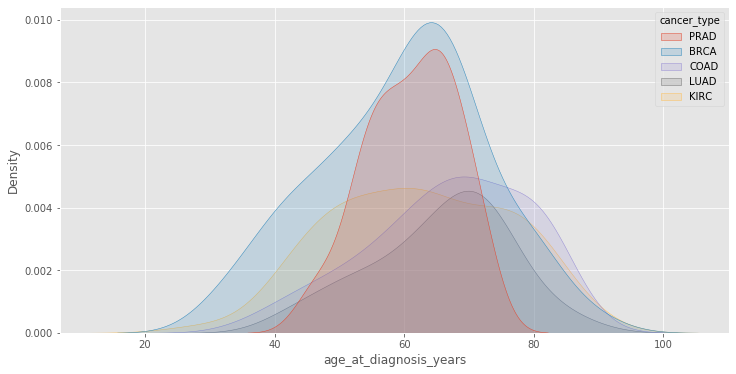

In [29]:
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)

sns.kdeplot(data=data, x='age_at_diagnosis_years', hue='cancer_type',
           fill=True, alpha=.2, ax=ax)
plt.show()

# 3. Hypothesis Testing

We’ll now go through some examples of how to perform 3 types of hypothesis tests: _One Sample T test or Z test,  Two Sample T test, and Analysis Of Variance._

## 3.1 One Sample
Say you want to answer the question

> Question1:
>
> Is the mean _age (in years) at diagnosis_ for 'KIRC' (kidney) cancer equal to 55?

### 3.1.1 One Sample T test
To tackle this, let's do a two-sided t test on the mean. A two-sided test simply means the alternative hypothesis does not care which way the mean differs from the selected value.

> $H_{0}: mean = 55$
>
> $H_{1}: mean \neq 55$
>
> $\alpha = 0.05$

We will compute the t value for the test by both first calculating it using the formula and by then using an existing function from the SciPy stats package. This way we will be able to compare and check our answers and then we'll be able to use one or the other depending on what we prefer.

Let's do a test with the hypotheses above for all samples of 'KIRC' cancer type.

In [111]:
# get subset for only the KIRC values
kirc_data = data.loc[data.cancer_type=='KIRC']

mu_k_age = np.mean(kirc_data['age_at_diagnosis_years']) # mean age of the KIRC data
sd_k_age = np.std(kirc_data['age_at_diagnosis_years'], ddof=1) # standard Dev of age for KIRC data, needs ddof = 1 for sample
n_k = len(kirc_data) # number of samples in KIRC data

t = (mu_k_age - 55)/(sd_k_age/np.sqrt(n_k)) # calculating the t-statitic value from formula
pval = 2*(1 - stats.t.cdf(np.abs(t), df=n_k-1)) # two-sided pvalue

print('t-statistic: {0:5f} \np-value : {1:5f}'.format(t, pval))

t-statistic: 4.422323 
p-value : 0.000038


In [112]:
# Call the 1 sample t test function from SciPy
stats.ttest_1samp(kirc_data.age_at_diagnosis_years, popmean=55)

Ttest_1sampResult(statistic=4.422322578447855, pvalue=3.7988529231288875e-05)

We see that we get the same values from both methods for both the __`test statistic = 4.422`__ and the __`p-value = 0.0004`__. At this point we might feel compel to look at the _p-value_ and interpret the value of our test, but we must hold on as we must always check the assumptions for our test. We also want to check for the __Type I__ error and __power__ or __Type II__ error for this type of test.

For the _One Sample T test_ to be valid, either of the following must hold: 
1. The population distribution is normal. 
    - _We can do a rough check visualy by either plotting the distibution or using a Q-Q plot
2. The sample size is sufficiently large.
    - _By tradition we tend to assume that sample sizes n > 30, we have a large enough sample size

For this test, we know that the sample size of the independent sample is 66, so already that is satisfied, but let's also check the plots to make sure we can see the _Normal Distribution_ in both the histogram and Q-Q plot.

/home/juansolo/anaconda3/envs/data558/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


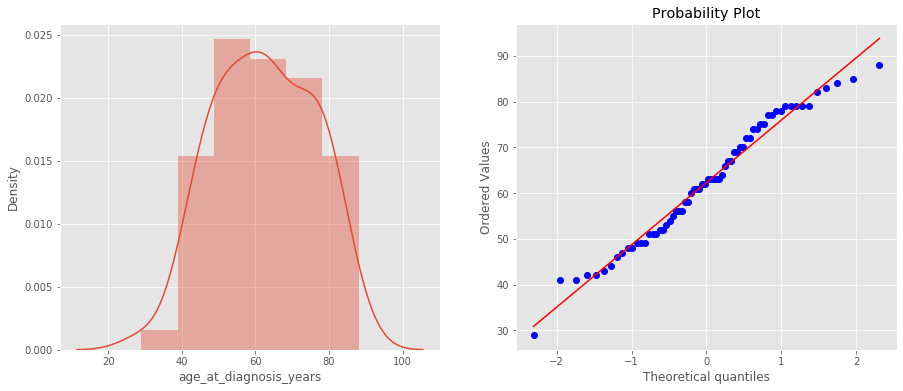

In [94]:
# setting figure parameters for size
fig_dims = (15, 6)
fig, ax = plt.subplots(1,2,figsize=fig_dims)

#Distribution from seaborn
sns.distplot(kirc_data['age_at_diagnosis_years'], kde=True, ax=ax[0]);

#QQ-plot plot from stats
stats.probplot(kirc_data['age_at_diagnosis_years'], dist="norm", plot=ax[1])
plt.show()

We see that it is both fairly normally distributed on the histogram/distribution plot, and that the values land in the Q-Q plot on the normality line.

Now to test the Type I error, we will do a _Simulation Study_ with the mean of the random distribution equal to the __$H_{0}: \mu=55$__ and the _standard deviation_ of the original "KIRC" data.  

In [102]:
def one_sample_simulation_values(N,n,mu,mu_0,sd_0,alpha=.95):
    """
        Runs Monte-Carlo simulations for a Normal Distribution of the described mean and standard dev. 
    
    """
    sims = []
    for i in range(N):
        
        # we can use either numpy or scipy.stats to create a sample of size n from a distribution
        samples_0 = np.random.normal(loc=mu_0, scale=sd_0, size=n)
        
        
        critical_value = stats.t.ppf(alpha, n-1)
        t = (np.mean(samples_0) - mu)/(np.std(samples_0,ddof=1)/np.sqrt(n))
        sims.append(np.abs(t) > np.abs(critical_value))
    
    return np.array(sims)

In [110]:
# we set a 'seed' number so that we can reproduce the random variable
np.random.seed(2)

# Checking the Type I error value from simulations
# we use mean to calculate this from the array returned by the function
print("Observed Alpha = {0:5f}".
      format(np.mean(one_sample_simulation_values(N=5000,n=n_k,mu=55,mu_0=55,sd_0=sd_k_age,alpha=.025))))

Observed Alpha = 0.047600


The Type I error rate is close to 0.05, agreeing with the theory quite well.

Now we can say by looking at the output from the hypothesis tests, the __`p-value = 0.0004`__ is << 0.05, the interpretation is that under the null hypothesis _mean age at diagnosis = 55_ , the probability of seeing a test statistic as extreme or more than what’s observed is __0.0004__ . Since this is less than our significance level of 0.05, we reject the null hypothesis. _mean age at diagnosis = 55._ 

#### One sided interpretation
The test above tells us that the mean _age at diagnosis_ is unlikely to be equal to 55, but what if we want to test whether the mean is specifically *greater than*  55? A one sided test has an alternative hypothesis that only goes one way:

> $H_{0}: mean = 55$
>
> $H_{1}: mean \gt 55$

As described in the background section, t is compared to the value of the t distribution at a certain point (the critical value). 

When doing a 'greater than' test, we reject the $H_{0}$ if t > critical value. 

When doing a 'less than' test, we reject the $H_{0}$ if t < critical value.

Since the t distribution is symmetrical around 0, the p value of the 'two sided' test we did before is simply 2 times the p value of either one sided test. 

&nbsp;

To interpret the results above for our one sided hypothesis test, we just need to observe:
1. The sign of the test statistic
2. P value divided by 2

&nbsp;

If  $H_{1}: mean \gt x$

The following is needed to reject the Null

- t > 0 
- (p/2) < $\alpha$ 

&nbsp;

If  $H_{1}: mean \lt x$

The following is needed to reject the Null

- t < 0 
- (p/2) < $\alpha$ 

&nbsp;

The results from the t test we did above have a t > 0, and (p/2) < 0.05.

Since we want to use it as a one sided test with $H_{1}: mean > 55$, these results reject $H_{0}$



### 3.1.2 Z test
Another test statistic that can be used for the one sample hypothesis testing is **z**. 

The formula for this is very similar to the t statistic:

$$
z = \frac{\overline{x} - m_{0}}{v * \sqrt{n}}
$$

The difference is that in place of the standard deviation of the sample, we use the variance of the population. This alternate test statistic can be used in situations where you know this information.

&nbsp;

Let's look at ___KIRC data___ again and test the following using the z statistic:

> $H_{0}: mean_{age \ at \ diagnosis} = 55$
>
> $H_{1}: mean_{age \ at \ diagnosis}\gt 55$
>
> $\alpha = 0.05$

The scipy stats package doesn't offer a simple z test function, so let's use the statsmodels package:

In [114]:
# SciPy z test, 'value' refers to the mean we are testing
sm.stats.ztest(kirc_data.age_at_diagnosis_years, value = 55, alternative = 'larger')

(4.422322578447855, 4.8822762370859695e-06)

Since z > 0 and p < $\alpha$, we reject that the mean age at diagnosis = 55. It is likely that the population mean is greater than 55. 

### 3.1.3 Confidence Intervals
Remember that Confidence intervals and hypothesis tests complement each other. We can think of the confidence interval as containing all the values that would not have been rejected by a corresponding hypothesis test. The confidence interval and hypothesis test complement each other, in most applications, it is a good idea to report the results of both.

So let's calculate the _Confidence Interval_ for our _"KIRC"_ data at the $\alpha=0.05$ level.

In [120]:
def confidence_interval(sample, alpha=0.05):
    """
        computes the confidence interval for the provided sample and alpha value, alpha is 0.05 by default.
    """
    n = len(sample)
    mu = np.mean(sample)
    sd = np.std(sample)
    return mu + stats.t.ppf(np.array([alpha/2, 1 - alpha/2]), df=n-1) * (sd/np.sqrt(n))

In [127]:
# computing confidence interval for KIRC data
lb, ub = confidence_interval(kirc_data.age_at_diagnosis_years)
print("The Lower Bound of the C.I. = {0:2f} , the Upper Bound of the C.I. = {1:2f}".format(lb, ub))

The Lower Bound of the C.I. = 59.046757 , the Upper Bound of the C.I. = 65.619910


We see that the _Null Hypothesis_ value for the _mean age at diagnosis = 55_ is outside the bounds of the _Confidence Interval_ , agreeing that we should reject the _Null Hypothesis_ .   

## 3.2 T Test on two samples
So far we've only asked questions about the mean of the underlying population for one sample. More often you might want to compare two samples.

Let's say you want to answer the following:

> Question 2:
>
> Is the mean _age (years) of diagnosis_ different between people with _Colon Cancer (COAD)_ versus people with _Kidney Cancer KIRC_ ?

The hypotheses would look like this:

> $H_{0}: mean_{COAD} = mean_{KIRC}$
>
> $H_{1}: mean_{COAD} \neq mean_{KIRC}$
> 
> $\alpha = 0.05$

Without getting into the formulas, which we already saw in the first section of this notebook, a test on two samples follows a similar process to one sample tests - a test statistic is computed and compared to critical values.

&nbsp;

**NOTE: The tests depend on how the samples relate to each other**

- Are the samples paired?
 - (e.g. If the two samples represent the same patients over two visits, then each value in one sample is 'paired' with a value in the other sample)
- Are the samples independent?
- Are the sample variances the same?

&nbsp;

Our data to answer Question 2 consists of the samples with the PRAD label and those with the LUAD label. These two groups are not paired, and they are independent. We will assume they have equal variance.

Let's use the SciPy function for two independent sample t test, it takes both samples as arguments. We should note that the function by default assumes equal variance, meaning that this would be a [_"Student's t-test"_](https://en.wikipedia.org/wiki/Student%27s_t-test) while if we set the `equal_var` to _False_ then we have a [_"Welch t-test"_](https://en.wikipedia.org/wiki/Welch%27s_t-test)(or _"unequal variances t-test"_ ).

We will use the _Welch t-test_ , both the _Student t-test_ and _Welch t-test_ calculate the same result when equal size and variance can be assumed for the samples, but the _Welch t-test_ performs better than _Student t-test_ whenever sample sizes and variances are unequal between the samples. 

In [155]:
# Select samples with PRAD and COAD, .isna() is used here to make sure to drop any nan values
prad = data.loc[(data['cancer_type'] == 'PRAD')&(~data.age_at_diagnosis_years.isna())]
coad = data.loc[(data['cancer_type'] == 'COAD')&(~data.age_at_diagnosis_years.isna())]

# Call the two sample t test function from scipy, and set 'equal_var' to False
tstat, pval = stats.ttest_ind(coad.age_at_diagnosis_years, prad.age_at_diagnosis_years)

mu_c_age = coad.age_at_diagnosis_years.mean()
mu_p_age = prad.age_at_diagnosis_years.mean()

print("COAD mean age at diagnosis: {0:2f} \t PRAD mean age at diagnosis: {1:2f}, \n\
test statistic: {2:2f} \t p-value: {3:2f}".format(mu_c_age, mu_p_age, tstat, pval))

COAD mean age at diagnosis: 66.793103 	 PRAD mean age at diagnosis: 61.126984, 
test statistic: 3.177007 	 p-value: 0.001896


The results above (p < $\alpha$) reject the hypothesis that the means are equal. It is likely that the mean _age at diagnosis_ is different in the population of people with PRAD versus those with LUAD, in fact we can see that the $mean_{age \ coad}=66.8$ and the $mean_{age \ prad}=61.1$.

## 3.3 ANOVA
Say you want to ask a question about many groups at once, such as:

> Question 3:
>
> Do all the different genes have the same underlying mean?

One-way Analysis of Variance (ANOVA) can be used to test this. Conceptually, the approach of ANOVA is to compare the variance *within* the individual groups to the variance *between* them. 

A test statistic called the F statistic is calculated and compared to critical values, as with simple hypothesis tests. 

&nbsp;

Let's use ANOVA to answer Question 3. First, our hypotheses:

> $H_{0}: \delta_{i} = 0$ for all samples 'i'
>
> $H_{1}: \delta_{i} \neq 0$ for at least one sample 'i'
>
> *where $\delta_{i}$ is the difference between the mean of group **i** and the overall mean*
> 
> $\alpha = 0.05$

To do this, let's make use of the one way ANOVA function from the statsmodels package. We assume equal variance for each group that we pick for the comparsion. The function defaults to equal variance so we do not have to specify that.

In [26]:
# Select a few genes to include in the comparison

# Rather than the usual method of subsetting a dataframe, we create a list of each 
# individual group because the statsmodels ANOVA function requires 
# a list of one dimensional arrays as input, rather than a two dimensional dataframe

gene_names = ['gene_1', 'gene_2', 'gene_6', 'gene_40']
gene_subset = []
for n in gene_names:
    gene_subset.append(data[n])

# Call the ANOVA function from statsmodels
anova_oneway(gene_subset)

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 10512.238291889496
pvalue = 0.0
df = (3.0, 1735.063883721622)
df_num = 3.0
df_denom = 1735.063883721622
nobs_t = 3204.0
n_groups = 4
means = [3.0109095  3.09534971 7.40550924 9.74568806]
nobs = [801. 801. 801. 801.]
vars_ = [1.44198674 1.13550587 1.22818983 0.50748198]
use_var = unequal
welch_correction = True
tuple = (10512.238291889496, 0.0)

The important thing to note is the p value, and $p < \alpha$. 

We can reject the hypothesis that all of these 4 selected genes have the same underlying mean.

# 4. Power and Sample Size

Great!!! Now we have both our gene expression data but also some demographics attached to them.

We now need to get the data for the Breast and Lung cancer for the **ENSG00000134982** gene to figure out if we have enough power with our current sample size and if not, what size is needed.



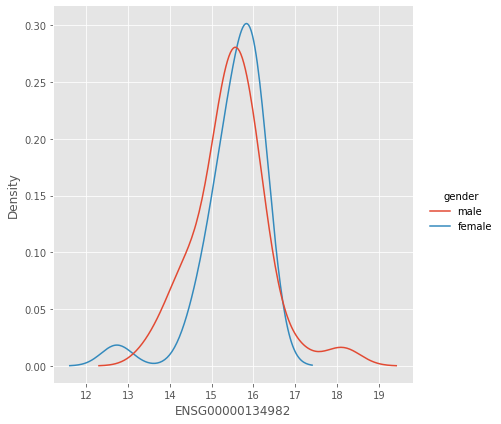

In [128]:
sns.displot(data=genes_small_log2.loc[genes_small_log2.cancer_type=='COAD'], x="ENSG00000134982", 
            hue="gender", kind="kde", height=6)

plt.show()

Ok we have a normal distribution for each of the cancer types in our data subset. 

Let's now create functions for the power and sample size calculations. For now we will make sure to run our simulations at an $\alpha = 0.01$.

In [80]:
np.random.seed(8911) # We set a seed for our random number generator for repudicibility

breast_cancer_ssample = genes_small_log2.loc[genes_small_log2.cancer_type == 'BRCA', ['ENSG00000134982']]
lung_cancer_ssample = genes_small_log2.loc[genes_small_log2.cancer_type == 'PRAD', ['ENSG00000134982']]

mu_0 = np.mean(breast_cancer_ssample.values) # mean of the first group
mu_1 = np.mean(lung_cancer_ssample.values) # mean of second group
sd_0 = np.std(breast_cancer_ssample.values) # first Population SD
sd_1 = np.std(lung_cancer_ssample.values) # second Population SD

# the parameters for our samples and number of simulations
n = 150 # Number of samples
N = 5000 # Number of simulations

def simulation_values(N,n,mu_0,mu_1,sd_0,sd_1, unequal_var=False):
    """
        Runs Monte-Carlo simulations for a Normal Distributions of the described means and standard dev. 
    
    """
    sims = []
    for i in range(N):
        
        # we can use either numpy or scipy.stats to create a sample of size n from a distribution
        # stats.norm.rvs(loc=mu, scale=sd, size=n), the scipy.stats version
        samples_0 = np.random.normal(loc=mu_0, scale=sd_0, size=n)
        samples_1 = np.random.normal(loc=mu_1, scale=sd_1, size=n)
        
        if unequal_var == True:
            critical_value, sds = unequal_variances(samples_0, samples_1, n)
        
        else:
            critical_value = stats.t.ppf(0.999, 2*n-2)
            sds = sd_0**2/n + sd_1**2/n
        
        t = (np.mean(samples_0) - np.mean(samples_1))/np.sqrt(sds)
        sims.append(np.abs(t) > np.abs(critical_value))
    
    return np.array(sims)



def unequal_variances(sample1, sample2, n):
    """
        Formula for calculating the degrees of freedom and standard dev for samples of unequal variances
    
    """
    sd1 = np.std(sample1)**2
    sd2 = np.std(sample2)**2
    sds = sd1/n + sd2/n
    degf = ((sds)**2) / ((sd1/n)**2/(n-1) + (sd2/n)**2/(n-1))
    critical_value = stats.t.ppf(0.999, degf)
    
    return critical_value, sds

    
def sample_size_required(power,N,n,mu_0,mu_1,sd_0,sd_1, unequal_var=False):
    """
        Calculates the minimum sample size needed to achive desired power
    
    """
    sim_power = 0
    power_values = list()
    while(sim_power <= power):
    
        simulation_value = [np.mean(simulation_values(N,n,mu_0,mu_1,sd_0,sd_1, unequal_var))]
        sim_power = np.mean(simulation_value)
        power_values.append([sim_power])
        
        print(n, sim_power)
    
        n += 1
    return n, np.array(power_values)
    
# print(sample_size_required(.90,N,n,mu_0,mu_1,sd_0,sd_1, unequal_var=True))
    
    

Alright, so now we have a way to calculate the needed sample size for our current experiment.

We know that we have at least a sample size of 100 from our genes dataset. We can test if that is more than enough of a sample size to reach the different levels of power we care about. Is it not enough? too much (meaning we are wasting resources)?

Let's run a simulation and start the sample size at 80 and see the power it gives us with the means and standard deviations of our samples.

In [79]:
n, power_values = sample_size_required(.90,N,80,mu_0,mu_1,sd_0,sd_1, unequal_var=True)

81 0.796
82 0.8074
83 0.8098
84 0.8244
85 0.8238
86 0.843
87 0.8428
88 0.8586
89 0.847
90 0.8432
91 0.8612
92 0.8706
93 0.8792
94 0.881
95 0.8798
96 0.8894
97 0.8908
98 0.893
99 0.9
100 0.903


Oh wow interesting!

We can see that at a sample size of 80 we have an approximate power of ~80% and we reach >90% once we have a sample size of ***>98 samples***.